# Learning latent representations with Autoencoders
> Training AutoRec and DeepAutoRec based simple and hybrid models on movielens-1m

- toc: true
- badges: true
- comments: true
- categories: [Tensorflow, Hybrid, Movie, AutoEncoder]
- image:

| |  |
| :-: | -:|
| Vision | Learn better embeddings using deep learning techniques |
| Mission | Use Autorec and its deep version to train simple and hybrid models  |
| Scope | Movie dataset, Model training and validation, Autorec and DeepAutoRec models |
| Task | Rating prediction |
| Data | Movielens-1m |
| Tool | Tensorflow 1.x, Colab, Python |
| Technique | AutoEncoder, DeepAutoEncoder, Collaborative Filtering, Hybrid Modeling |
| Process | 1) Data ETL, 2) Data Preprocessing, 3) AutoRec model training, 4) DeepAutoRec model training, 5) Denoising experiment, 6) Hybrid modeling experiment |
| Takeaway | Autoencoders are effective to learn embeddings, Hybrid models might not improve model performance in case of rating imbalance |
| Credit | [Zheda (Marco) Mai](https://github.com/RaptorMai) |
| Link | [link1](https://github.com/RaptorMai/Deep-AutoEncoder-Recommendation), [link2](http://cseweb.ucsd.edu/~gary/pubs/mehrab-cikm-2020.pdf) |

Autoencoder has been widely adopted into Collaborative Filtering (CF) for recommendation system. A classic CF problem is inferring the missing rating in an MxN matrix R where R(i, j) is the ratings given by the i<sup>th</sup> user to the j<sup>th</sup> item. This project is a Keras implementation of  AutoRec and Deep AutoRec and additional experiments will be run. 

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [32]:
import os
import math
import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras.utils import plot_model
from scipy.sparse import csr_matrix

import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import initializers
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.python.keras.models import model_from_json
from tensorflow.python.keras.optimizers import Adam, RMSprop
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.keras.layers import add, concatenate
from tensorflow.python.keras.layers import Input, Dense, Embedding, Flatten
from tensorflow.python.keras.layers import  Dropout, merge, Activation, BatchNormalization, LeakyReLU

%matplotlib inline
warnings.filterwarnings('ignore')

## ETL

The raw data file is separated by ```::``` without headers. This part is transforming the raw data file into a CSV with headers, which can be easily imported using Pandas in the following parts. All the user and movie id will be subtracted by 1 for zero-based index. The snippet shows the preprocessing for rating data and similar preprocessing is applied to users data and movies data.

### Extract

In [3]:
!wget http://files.grouplens.org/datasets/movielens/ml-1m.zip

--2021-07-18 15:28:35--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  12.1MB/s    in 0.5s    

2021-07-18 15:28:36 (12.1 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]



In [4]:
!unzip ml-1m.zip

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


### Transform

In [5]:
# variables
BASE_DIR = '/content' 
MOVIELENS_DIR = BASE_DIR + '/ml-1m/'
USER_DATA_FILE = 'users.dat'
MOVIE_DATA_FILE = 'movies.dat'
RATING_DATA_FILE = 'ratings.dat'

# ref http://files.grouplens.org/datasets/movielens/ml-1m-README.txt
AGES = { 1: "Under 18", 18: "18-24", 25: "25-34", 35: "35-44", 45: "45-49", 50: "50-55", 56: "56+" }
OCCUPATIONS = { 0: "other or not specified", 1: "academic/educator", 2: "artist", 3: "clerical/admin",
                4: "college/grad student", 5: "customer service", 6: "doctor/health care",
                7: "executive/managerial", 8: "farmer", 9: "homemaker", 10: "K-12 student", 11: "lawyer",
                12: "programmer", 13: "retired", 14: "sales/marketing", 15: "scientist", 16: "self-employed",
                17: "technician/engineer", 18: "tradesman/craftsman", 19: "unemployed", 20: "writer" }
                
RATINGS_CSV_FILE = 'ml1m_ratings.csv'
USERS_CSV_FILE = 'ml1m_users.csv'
MOVIES_CSV_FILE = 'ml1m_movies.csv'

In [6]:
ratings = pd.read_csv(os.path.join(MOVIELENS_DIR, RATING_DATA_FILE), 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['userid', 'movieid', 'rating', 'timestamp'])

max_userid = ratings['userid'].drop_duplicates().max()
max_movieid = ratings['movieid'].drop_duplicates().max()

ratings['user_emb_id'] = ratings['userid'] - 1
ratings['movie_emb_id'] = ratings['movieid'] - 1

print(len(ratings), 'ratings loaded')

ratings.to_csv(RATINGS_CSV_FILE, 
               sep='\t', 
               header=True, 
               encoding='latin-1', 
               columns=['user_emb_id', 'movie_emb_id', 'rating', 'timestamp'])

print('Saved to', RATINGS_CSV_FILE)

1000209 ratings loaded
Saved to ml1m_ratings.csv


In [7]:
users = pd.read_csv(os.path.join(MOVIELENS_DIR, USER_DATA_FILE), 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['userid', 'gender', 'age', 'occupation', 'zipcode'])

users['age_desc'] = users['age'].apply(lambda x: AGES[x])
users['occ_desc'] = users['occupation'].apply(lambda x: OCCUPATIONS[x])

print(len(users), 'descriptions of', max_userid, 'users loaded.')

users['user_emb_id'] = users['userid'] - 1

users.to_csv(USERS_CSV_FILE, 
             sep='\t', 
             header=True, 
             encoding='latin-1',
             columns=['user_emb_id', 'gender', 'age', 'occupation', 'zipcode', 'age_desc', 'occ_desc'])

print('Saved to', USERS_CSV_FILE)

6040 descriptions of 6040 users loaded.
Saved to ml1m_users.csv


In [8]:
movies = pd.read_csv(os.path.join(MOVIELENS_DIR, MOVIE_DATA_FILE), 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['movieid', 'title', 'genre'])

print(len(movies), 'descriptions of', max_movieid, 'movies loaded.')

movies['movie_emb_id'] = movies['movieid'] - 1

movies.to_csv(MOVIES_CSV_FILE, 
              sep='\t', 
              header=True, 
              columns=['movie_emb_id', 'title', 'genre'])

print('Saved to', MOVIES_CSV_FILE)

3883 descriptions of 3952 movies loaded.
Saved to ml1m_movies.csv


### Load

In [9]:
df = pd.read_csv(RATINGS_CSV_FILE, sep='\t', encoding='latin-1', 
                      usecols=['user_emb_id', 'movie_emb_id', 'rating', 'timestamp'])

df.head(5)

,user_emb_id,movie_emb_id,rating,timestamp
0,0,1192,5,978300760
1,0,660,3,978302109
2,0,913,3,978301968
3,0,3407,4,978300275
4,0,2354,5,978824291


## Preprocessing

### Label encode

In [10]:
le_user = preprocessing.LabelEncoder()
df.loc[:, 'user_emb_id'] = le_user.fit_transform(df['user_emb_id'].values)

le_item = preprocessing.LabelEncoder()
df.loc[:, 'movie_emb_id'] = le_item.fit_transform(df['movie_emb_id'].values)

In [11]:
num_users = df['user_emb_id'].nunique()
num_movies = df['movie_emb_id'].nunique()

num_users, num_movies

(6040, 3706)

### Train/val/test split

Split the data into random 90%–10% train-test sets, and hold out 10% of the training set for validation.

Using **Stratify with user_id** . This setting is critical, without this setting, it's possible that reviews of one user are all split into one the training or test set and cause bias. For example if all the reviews of user A are put into the training set, then during test time, there is no test data for this user. The test RMSE will be 0 for this user. On the other hand, if all reviews are put into test set, then there is no review for this user during training time and cause the RMSE higher for this user.  

In [12]:
train_df, test_df = train_test_split(df,
                                     stratify=df['user_emb_id'],
                                     test_size=0.1,
                                     random_state=42)  

In [13]:
train_df, validate_df = train_test_split(train_df,
                                 stratify=train_df['user_emb_id'],
                                 test_size=0.1,
                                 random_state=42)  

### Creating a sparse pivot table with users in rows and items in columns

In order to apply AutoRec on the dataset, the dataset should be transformed to a MxN matrix where R(i, j) is the ratings given by the i<sup>th</sup> user to the j<sup>th</sup> item. The function ```dataPreprocessor``` is used for this transformation. The init_value is the default rating for unobserved ratings. If ```average ``` is set to ```True```, the unobvserved rating will be set as the average rating of the user.

In [14]:
def dataPreprocessor(rating_df, num_users, num_items, init_value=0, average=False):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
    """
    if average:
      matrix = np.full((num_users, num_items), 0.0)
      for (_, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID, itemID] = rating
      avergae = np.true_divide(matrix.sum(1), np.maximum((matrix!=0).sum(1), 1))
      inds = np.where(matrix == 0)
      matrix[inds] = np.take(avergae, inds[0])
      
    else:
      matrix = np.full((num_users, num_items), init_value)
      for (_, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID, itemID] = rating

    return matrix

In the Deep_AE_CF paper, the default rating is 0 while in the AutoRec paper, the default rating is 3. So, we decided to tried different default ratings.

In [15]:
users_items_matrix_train_zero = dataPreprocessor(train_df, num_users, num_movies, 0)
users_items_matrix_train_one = dataPreprocessor(train_df, num_users, num_movies, 1)
users_items_matrix_train_two = dataPreprocessor(train_df, num_users, num_movies, 2)
users_items_matrix_train_three = dataPreprocessor(train_df, num_users, num_movies, 3)
users_items_matrix_train_four = dataPreprocessor(train_df, num_users, num_movies, 4)
users_items_matrix_train_five = dataPreprocessor(train_df, num_users, num_movies, 5)

users_items_matrix_train_average = dataPreprocessor(train_df, num_users, num_movies, average=True)

users_items_matrix_validate = dataPreprocessor(validate_df, num_users, num_movies, 0)

users_items_matrix_test = dataPreprocessor(test_df, num_users, num_movies, 0)

## Util functions

### Plots

In [16]:
def show_error(history, skip):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  plt.plot(np.arange(skip, len(loss), 1), loss[skip:])
  plt.plot(np.arange(skip, len(loss), 1), val_loss[skip:])
  plt.title('model train vs validation loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='best')
  plt.show()

In [17]:
def show_rmse(history, skip):
  rmse = history.history['masked_rmse_clip']
  val_rmse = history.history['val_masked_rmse_clip']
  plt.plot(np.arange(skip, len(rmse), 1), rmse[skip:])
  plt.plot(np.arange(skip, len(val_rmse), 1), val_rmse[skip:])
  plt.title('model train vs validation masked_rmse')
  plt.ylabel('rmse')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='best')
  plt.show()

### Save and load model

In [18]:
def load_model(name):
  # load json and create model
  model_file = open('{}.json'.format(name), 'r')
  loaded_model_json = model_file.read()
  model_file.close()
  loaded_model = model_from_json(loaded_model_json)
  # load weights into new model
  loaded_model.load_weights("{}.h5".format(name))
  print("Loaded model from disk")
  return loaded_model

In [19]:
def save_model(name, model):
  # # serialize model to JSON
  model_json = model.to_json()
  with open("{}.json".format(name), "w") as json_file:
      json_file.write(model_json)
  # serialize weights to HDF5
  model.save_weights("{}.h5".format(name))
  print("Saved model to disk")

### Custom loss functions

Since it does not make sense to predict zero in the user rating vector, we follow the AutoRec paper to minimize the Masked Mean Squared Error(MMSE).

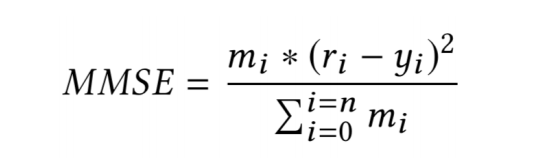

where r<sub>i</sub> is the actual rating and y<sub>i</sub> is the reconstructed rating. m<sub>i</sub> is a mask function where m<sub>i</sub> =1 where  r<sub>i</sub> is non-zero else m<sub>i</sub>=0. 

Since Masked Mean Squared Error is not provided in Keras, so we customized the error function.

In [20]:
def masked_se(y_true, y_pred):
  # masked function
  mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
  # masked squared error
  masked_squared_error = K.square(mask_true * (y_true - y_pred))
  masked_mse = K.sum(masked_squared_error, axis=-1)
  return masked_mse

In [21]:
def masked_mse(y_true, y_pred):
  # masked function
  mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
  # masked squared error
  masked_squared_error = K.square(mask_true * (y_true - y_pred))
  masked_mse = K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1)
  return masked_mse

In [22]:
def masked_rmse(y_true, y_pred):
  # masked function
  mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
  # masked squared error
  masked_squared_error = K.square(mask_true * (y_true - y_pred))
  masked_mse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
  return masked_mse

The performance of the model is measured by the Masked Root Mean Squared Error (MRMSE). Similar to MMSE, we only take into consideration the error where the rating is not zero in the test set. Also, clipping the predicted rating with 1 as minimum and 5 as maximum.

In [23]:
def masked_rmse_clip(y_true, y_pred):
  # masked function
  mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
  y_pred = K.clip(y_pred, 1, 5)
  # masked squared error
  masked_squared_error = K.square(mask_true * (y_true - y_pred))
  masked_mse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
  return masked_mse

### Test custom loss function

In [24]:
y_pred = K.constant([[ 1, 1, 1, 3]])

y_true = K.constant([[ 0, 0, 1, 1]])
true = K.eval(y_true)
pred = K.eval(y_pred)
loss = K.eval(masked_se(y_true, y_pred))
rmse = K.eval(masked_rmse(y_true, y_pred))

for i in range(true.shape[0]):
    print(true[i], pred[i], loss[i], rmse[i], sep='\t')

[0. 0. 1. 1.]	[1. 1. 1. 3.]	4.0	1.4142135


In [25]:
y_pred = K.constant([[ 1, 1, 1, 1], 
                     [ 1, 1, 1, 8],
                     [ 1, 1, 1, 3],
                     [ 1, 1, 1, 3],
                     [ 1, 1, 1, 3],
                     [ 1, 1, 1, 3]])

y_true = K.constant([[ 1, 1, 1, 1],
                     [ 1, 1, 1, 1],
                     [ 0, 1, 1, 1],
                     [ 0, 0, 1, 1],
                     [ 0, 0, 0, 1],
                     [ 0, 0, 0, 0]])

true = K.eval(y_true)
pred = K.eval(y_pred)
loss = K.eval(masked_se(y_true, y_pred))
rmse = K.eval(masked_rmse(y_true, y_pred))

for i in range(true.shape[0]):
    print(true[i], pred[i], loss[i], rmse[i], sep='\t')

[1. 1. 1. 1.]	[1. 1. 1. 1.]	0.0	0.0
[1. 1. 1. 1.]	[1. 1. 1. 8.]	49.0	3.5
[0. 1. 1. 1.]	[1. 1. 1. 3.]	4.0	1.1547005
[0. 0. 1. 1.]	[1. 1. 1. 3.]	4.0	1.4142135
[0. 0. 0. 1.]	[1. 1. 1. 3.]	4.0	2.0
[0. 0. 0. 0.]	[1. 1. 1. 3.]	0.0	0.0


## AutoRec

The model we are going to implement is a user-based AutoRec, which take the partially observed ratings vector of a user, project it into a low dimensional latent space and then reconstruct back to the output space to predict the missing rating. 

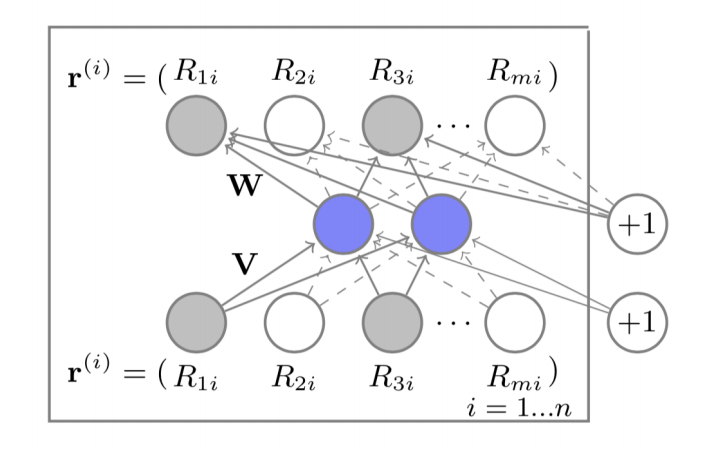

In [54]:
def AutoRec(X, reg, first_activation, last_activation):
    '''
    AutoRec
        INPUT: 
          X: #_user X #_item matrix
          reg: L2 regularization parameter
          first_activation: activation function for first dense layer
          last_activation: activation function for second dense layer
        
        OUTPUT:
          Keras model
    
    '''
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    x = Dense(500, activation=first_activation, name='LatentSpace', kernel_regularizer=regularizers.l2(reg))(x)
    output_layer = Dense(X.shape[1], activation=last_activation, name='UserScorePred', kernel_regularizer=regularizers.l2(reg))(x)
    model = Model(input_layer, output_layer)

    return model

In [27]:
def AutoRec_LReLU(X, reg):
    '''
    AutoRec
    LReLu is not implemented in to Dense 
    Need to have seperate LeakyRelu layer 
    '''
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    x = Dense(500, name='LatentSpace', kernel_regularizer=regularizers.l2(reg))(x)
    x = LeakyReLU()(x)
    output_layer = Dense(X.shape[1], activation='linear', name='UserScorePred',kernel_regularizer=regularizers.l2(reg))(x)
    model = Model(input_layer, output_layer)

    return model

In [28]:
# Build model
model = AutoRec(users_items_matrix_train_zero, 0.0005, 'elu', 'elu')
model.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      [(None, 3706)]            0         
_________________________________________________________________
LatentSpace (Dense)          (None, 500)               1853500   
_________________________________________________________________
UserScorePred (Dense)        (None, 3706)              1856706   
Total params: 3,710,206
Trainable params: 3,710,206
Non-trainable params: 0
_________________________________________________________________


**Baseline settings of AutoRec**

| L2 Regularization | Optimizer | Learning Rate | Epochs | Batch Size | Activations      | Default Rating |
| :---------------: | :-------: | :-----------: | ------ | :--------: | ---------------- | :------------: |
|       0.001       |   Adam    |    0.0001     | 500    |    256     | Sigmoid + Linear |       0        |

In [29]:
#hide-output
hist_Autorec = model.fit(x=users_items_matrix_train_average, y=users_items_matrix_train_zero,
                  epochs=500,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=[users_items_matrix_train_average, users_items_matrix_validate])

Train on 6040 samples, validate on 6040 samples
Epoch 1/500
6040/6040 - 2s - loss: 7.3402 - masked_rmse_clip: 1.8790 - val_loss: 3.6471 - val_masked_rmse_clip: 1.3182
Epoch 2/500
6040/6040 - 1s - loss: 2.5951 - masked_rmse_clip: 1.1537 - val_loss: 2.0322 - val_masked_rmse_clip: 0.9781
Epoch 3/500
6040/6040 - 1s - loss: 1.8965 - masked_rmse_clip: 0.9733 - val_loss: 1.8322 - val_masked_rmse_clip: 0.9264
Epoch 4/500
6040/6040 - 1s - loss: 1.7510 - masked_rmse_clip: 0.9385 - val_loss: 1.7384 - val_masked_rmse_clip: 0.9088
Epoch 5/500
6040/6040 - 1s - loss: 1.6952 - masked_rmse_clip: 0.9276 - val_loss: 1.7109 - val_masked_rmse_clip: 0.9056
Epoch 6/500
6040/6040 - 1s - loss: 1.6739 - masked_rmse_clip: 0.9264 - val_loss: 1.6959 - val_masked_rmse_clip: 0.9065
Epoch 7/500
6040/6040 - 1s - loss: 1.6596 - masked_rmse_clip: 0.9270 - val_loss: 1.6818 - val_masked_rmse_clip: 0.9053
Epoch 8/500
6040/6040 - 1s - loss: 1.6434 - masked_rmse_clip: 0.9260 - val_loss: 1.6639 - val_masked_rmse_clip: 0.9039


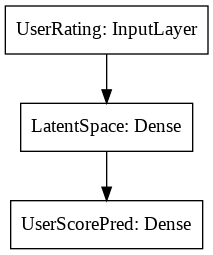

In [35]:
tf.keras.utils.plot_model(model)

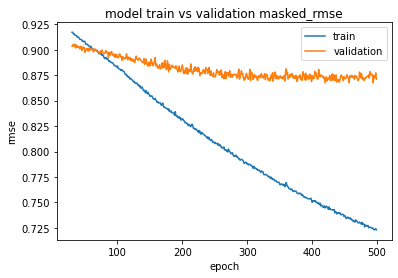

In [36]:
show_rmse(hist_Autorec, 30)

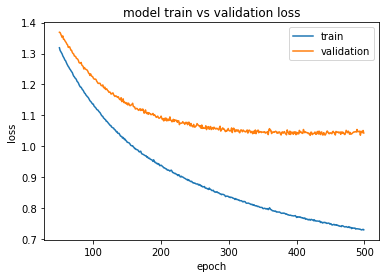

In [37]:
show_error(hist_Autorec, 50)

In [38]:
test_result = model.evaluate(users_items_matrix_train_average, users_items_matrix_test)

6040/6040 [==============================] - 0s 77us/sample - loss: 1.0588 - masked_rmse_clip: 0.8819


All the hyper-parameters including L2, lambda, learning rate and epochs are not fine-tuned, so the result is not as good as the AutoRec paper. But we can found 2 things:
1. Activations that perform well in Deep Autoencoder CF do not outperform the Sigmoid+Linear baseline.
2. When changing the activation from Sigmod to other activations with unbounded positive part, the model is easier to overfit. 

## Deep AutoRec

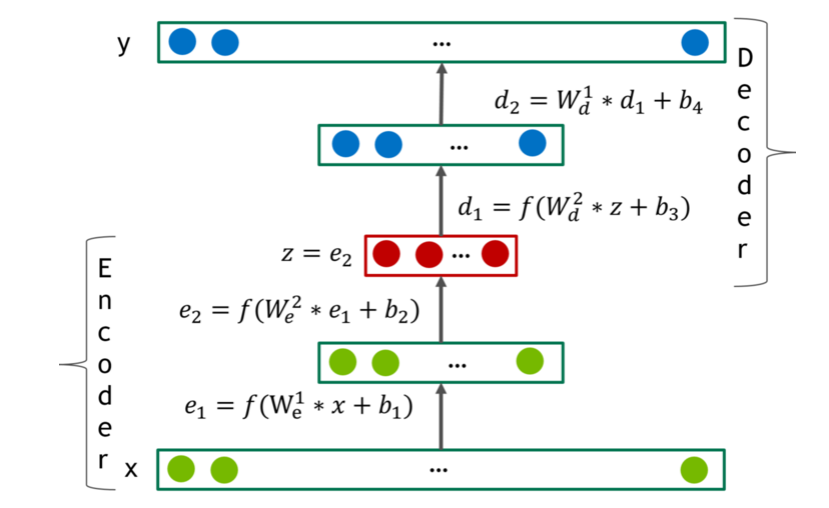

In [60]:
def Deep_AE_model(X, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode, side_infor_size=0):
    '''
    Build Deep AE for CF
        INPUT: 
            X: #_user X #_item matrix
            layers: List, each element is the number of neuron for a layer
            reg: L2 regularization parameter
            activation: activation function for all dense layer except the last
            last_activation: activation function for the last dense layer
            dropout: dropout rate
            regularizer_encode: regularizer for encoder
            regularizer_decode: regularizer for decoder
            side_infor_size: size of the one hot encoding side information
        OUTPUT:
            Keras model
    '''

    # Input
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    
    # Encoder
    # -----------------------------
    k = int(len(layers)/2)
    i = 0
    for l in layers[:k]:
      x = Dense(l, activation=activation,
                      name='EncLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_encode))(x)
      i = i+1
      
      
    # Latent Space
    # -----------------------------
    x = Dense(layers[k], activation=activation, 
                                name='LatentSpace', kernel_regularizer=regularizers.l2(regularizer_encode))(x)
    
    # Dropout
    x = Dropout(rate = dropout)(x)
    
    # Decoder
    # -----------------------------
    for l in layers[k+1:]:
      i = i-1
      x = Dense(l, activation=activation, 
                      name='DecLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_decode))(x)
      
    # Output

    output_layer = Dense(X.shape[1]-side_infor_size, activation=last_activation, name='UserScorePred', kernel_regularizer=regularizers.l2(regularizer_decode))(x)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)

    return model

In [40]:
layers = [256, 512, 256]
#layers = [512, 256, 128, 256, 512]
#layers = [512, 256, 512]
#layers = [128, 256, 512, 256, 128]
#layers = [512, 512, 512]
dropout = 0.8
# activation = 'sigmoid'
# last_activation = 'linear'
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001

| L2 Regularization | Optimizer | Learning Rate | Epochs | Batch Size | Activations | Default Rating | Dropout |
| :---------------: | :-------: | :-----------: | ------ | :--------: | ----------- | :------------: | :-----: |
|       0.001       |   Adam    |    0.0001     | 500    |    256     | SELU+SELU   |       0        |   0.8   |

In [41]:
# Build model
model = Deep_AE_model(users_items_matrix_train_zero, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode)
model.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) 
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      [(None, 3706)]            0         
_________________________________________________________________
EncLayer0 (Dense)            (None, 256)               948992    
_________________________________________________________________
LatentSpace (Dense)          (None, 512)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
DecLayer0 (Dense)            (None, 256)               131328    
_________________________________________________________________
UserScorePred (Dense)        (None, 3706)              952442    
Total params: 2,164,346
Trainab

In [42]:
#hide-output
hist_Deep_AE = model.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero,
                  epochs=500,
                  batch_size=256,
                  validation_data=[users_items_matrix_train_zero, users_items_matrix_validate], verbose=2)

Train on 6040 samples, validate on 6040 samples
Epoch 1/500
6040/6040 - 1s - loss: 16.1387 - masked_rmse_clip: 2.8473 - val_loss: 13.5722 - val_masked_rmse_clip: 2.7921
Epoch 2/500
6040/6040 - 1s - loss: 10.7914 - masked_rmse_clip: 2.4359 - val_loss: 6.4369 - val_masked_rmse_clip: 1.9011
Epoch 3/500
6040/6040 - 1s - loss: 6.0783 - masked_rmse_clip: 1.8073 - val_loss: 3.8546 - val_masked_rmse_clip: 1.3759
Epoch 4/500
6040/6040 - 1s - loss: 4.2739 - masked_rmse_clip: 1.4884 - val_loss: 3.0795 - val_masked_rmse_clip: 1.1467
Epoch 5/500
6040/6040 - 1s - loss: 3.7242 - masked_rmse_clip: 1.3628 - val_loss: 2.8590 - val_masked_rmse_clip: 1.0774
Epoch 6/500
6040/6040 - 1s - loss: 3.5186 - masked_rmse_clip: 1.3150 - val_loss: 2.7444 - val_masked_rmse_clip: 1.0429
Epoch 7/500
6040/6040 - 1s - loss: 3.3807 - masked_rmse_clip: 1.2848 - val_loss: 2.6653 - val_masked_rmse_clip: 1.0203
Epoch 8/500
6040/6040 - 1s - loss: 3.2707 - masked_rmse_clip: 1.2608 - val_loss: 2.6082 - val_masked_rmse_clip: 1.00

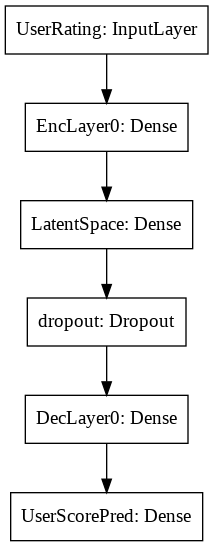

In [62]:
tf.keras.utils.plot_model(Deep_AE)

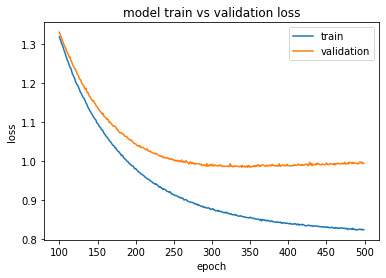

In [43]:
show_error(hist_Deep_AE, 100)

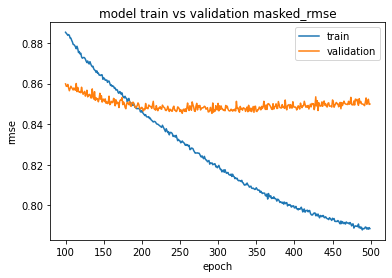

In [44]:
show_rmse(hist_Deep_AE, 100)

In [45]:
test_result_deep = model.evaluate(users_items_matrix_train_zero, users_items_matrix_test)

6040/6040 [==============================] - 1s 93us/sample - loss: 1.0028 - masked_rmse_clip: 0.8579


### Findings
1. When we compared the average and zero as default rating in AutoRec, we found that average converged faster but with noise. But when the model goes deeper, **the zero default rating converged faster and with less noise.** However, when we take a look at the loss, the gap between training and validation is larger in zero default setting. This means when we use zero as default rating, the model is easier to overfit. 
2. Adding more layers does not help for both BSB and SBS shape. As we go deeper, it’s easier to get overfitted and increasing the regularization parameters will bring the test performance down. So, our case, using three hidden layers is the best option.
3. `[512, 256, 512]` and `[256, 512, 256]` have similar performance but `[256, 512, 256]` has half the number of parameters. So we used `[256, 512, 256]`, as fewer parameters not only allows us to train model with less data but also can mitigate overfitting. 

In [46]:
for layer in model.layers: 
  print(layer.get_config())

{'batch_input_shape': (None, 3706), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'UserRating'}
{'name': 'EncLayer0', 'trainable': True, 'dtype': 'float32', 'units': 256, 'activation': 'selu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None, 'dtype': 'float32'}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {'dtype': 'float32'}}, 'kernel_regularizer': {'class_name': 'L1L2', 'config': {'l1': 0.0, 'l2': 0.0010000000474974513}}, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
{'name': 'LatentSpace', 'trainable': True, 'dtype': 'float32', 'units': 512, 'activation': 'selu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None, 'dtype': 'float32'}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {'dtype': 'float32'}}, 'kernel_regularizer': {'class_name': 'L1L2', 'config': {'l1': 0.0, 'l2': 0.0010000000474974513

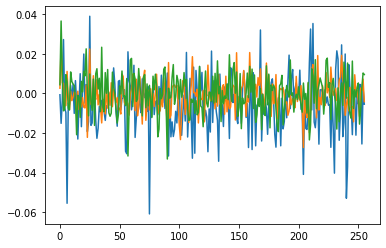

In [48]:
first_layer_weights = model.layers[1].get_weights()[0]
plt.plot(np.arange(0, 256, 1), first_layer_weights[0])
plt.plot(np.arange(0, 256, 1), first_layer_weights[1])
plt.plot(np.arange(0, 256, 1), first_layer_weights[2])
plt.show()

> Note: Lot of noise.

## Denoising

Common corruption choices are the additive Gaussian noise and multiplicative dropout noise. In the Denoising paper, authors used multiplicative dropout noise.

#### Gussian AutoRec

In [49]:
## Adding Gaussin noise to input
noise_factor = 0.4
users_items_matrix_train_average_noisy = users_items_matrix_train_average + noise_factor * np.random.normal(size=users_items_matrix_train_zero.shape) 
users_items_matrix_train_zero_noisy = users_items_matrix_train_zero + noise_factor * np.random.normal(size=users_items_matrix_train_zero.shape) 

In [55]:
#hide-output
model = AutoRec(users_items_matrix_train_average_noisy, 0.001, 'elu', 'elu')

model.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip])

hist_Autorec = model.fit(x=users_items_matrix_train_average_noisy, y=users_items_matrix_train_zero,
                  epochs=500,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=[users_items_matrix_train_average_noisy, users_items_matrix_validate])

Train on 6040 samples, validate on 6040 samples
Epoch 1/500
6040/6040 - 1s - loss: 8.5410 - masked_rmse_clip: 1.9206 - val_loss: 4.4458 - val_masked_rmse_clip: 1.3332
Epoch 2/500
6040/6040 - 1s - loss: 3.4432 - masked_rmse_clip: 1.1731 - val_loss: 2.8632 - val_masked_rmse_clip: 0.9918
Epoch 3/500
6040/6040 - 1s - loss: 2.6632 - masked_rmse_clip: 0.9804 - val_loss: 2.5746 - val_masked_rmse_clip: 0.9296
Epoch 4/500
6040/6040 - 1s - loss: 2.5045 - masked_rmse_clip: 0.9452 - val_loss: 2.5005 - val_masked_rmse_clip: 0.9215
Epoch 5/500
6040/6040 - 1s - loss: 2.4382 - masked_rmse_clip: 0.9392 - val_loss: 2.4411 - val_masked_rmse_clip: 0.9183
Epoch 6/500
6040/6040 - 1s - loss: 2.3877 - masked_rmse_clip: 0.9375 - val_loss: 2.3988 - val_masked_rmse_clip: 0.9182
Epoch 7/500
6040/6040 - 1s - loss: 2.3443 - masked_rmse_clip: 0.9367 - val_loss: 2.3587 - val_masked_rmse_clip: 0.9177
Epoch 8/500
6040/6040 - 1s - loss: 2.3031 - masked_rmse_clip: 0.9359 - val_loss: 2.3191 - val_masked_rmse_clip: 0.9189


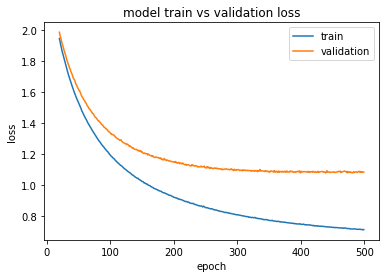

In [56]:
show_error(hist_Autorec, 20)

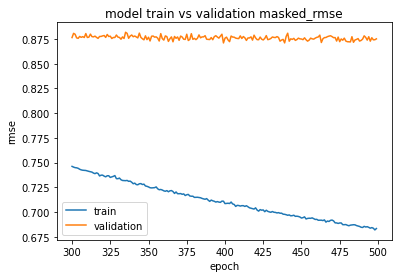

In [57]:
show_rmse(hist_Autorec, 300)

In [59]:
test_result_deep = model.evaluate(users_items_matrix_train_average_noisy, users_items_matrix_test)

6040/6040 [==============================] - 1s 85us/sample - loss: 1.1024 - masked_rmse_clip: 0.8857


#### Gaussian Deep AE CF

In [63]:
layers = [256, 512, 256]
dropout = 0.8

activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001

In [64]:
# Build model
model = Deep_AE_model(users_items_matrix_train_zero_noisy, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode)
model.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) 
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      [(None, 3706)]            0         
_________________________________________________________________
EncLayer0 (Dense)            (None, 256)               948992    
_________________________________________________________________
LatentSpace (Dense)          (None, 512)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
DecLayer0 (Dense)            (None, 256)               131328    
_________________________________________________________________
UserScorePred (Dense)        (None, 3706)              952442    
Total params: 2,164,346
Trainable params: 2,164,346
Non-trainable params: 0
_________________________________________________

In [65]:
#hide-output
hist_Deep_AE_denoise = model.fit(x=users_items_matrix_train_zero_noisy, y=users_items_matrix_train_zero,
                  epochs=500,
                  batch_size=256,
                  validation_data=[users_items_matrix_train_zero_noisy, users_items_matrix_validate], verbose=2)

Train on 6040 samples, validate on 6040 samples
Epoch 1/500
6040/6040 - 1s - loss: 16.3408 - masked_rmse_clip: 2.8457 - val_loss: 14.3281 - val_masked_rmse_clip: 2.8203
Epoch 2/500
6040/6040 - 1s - loss: 11.3391 - masked_rmse_clip: 2.4845 - val_loss: 7.1135 - val_masked_rmse_clip: 2.0116
Epoch 3/500
6040/6040 - 1s - loss: 6.6426 - masked_rmse_clip: 1.8715 - val_loss: 4.3395 - val_masked_rmse_clip: 1.4900
Epoch 4/500
6040/6040 - 1s - loss: 4.7177 - masked_rmse_clip: 1.5695 - val_loss: 3.3290 - val_masked_rmse_clip: 1.2140
Epoch 5/500
6040/6040 - 1s - loss: 4.0117 - masked_rmse_clip: 1.4214 - val_loss: 3.0145 - val_masked_rmse_clip: 1.1168
Epoch 6/500
6040/6040 - 1s - loss: 3.7313 - masked_rmse_clip: 1.3567 - val_loss: 2.8805 - val_masked_rmse_clip: 1.0762
Epoch 7/500
6040/6040 - 1s - loss: 3.5879 - masked_rmse_clip: 1.3239 - val_loss: 2.7974 - val_masked_rmse_clip: 1.0518
Epoch 8/500
6040/6040 - 1s - loss: 3.4775 - masked_rmse_clip: 1.3008 - val_loss: 2.7322 - val_masked_rmse_clip: 1.03

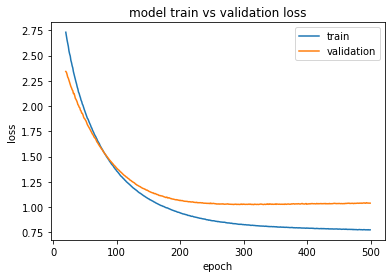

In [66]:
show_error(hist_Deep_AE_denoise, 20)

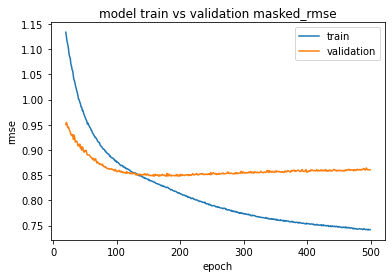

In [67]:
show_rmse(hist_Deep_AE_denoise, 20)

In [68]:
test_result_deep = model.evaluate(users_items_matrix_train_zero_noisy, users_items_matrix_test)

6040/6040 [==============================] - 1s 90us/sample - loss: 1.0446 - masked_rmse_clip: 0.8673


In [69]:
predict_deep = model.predict(users_items_matrix_train_zero_noisy)
loss = K.eval(masked_rmse_clip( 
    K.constant((users_items_matrix_train_zero)), 
    K.constant(predict_deep)))
np.mean(loss)

0.70405453

Adding Gaussian Noise did not improve the model. As default rating has an impact on the performance, adding noise is changing the default rating and this may be one potential reason. Deep AutoRec has the similar graph as AutoRec.

### Dropout Noise

In the denoising paper, it masked out non-zero elements randomly in each batch and use the masked input. However, using Keras to implement this feature will be the same as using pure TensorFlow. Due to the time limit of this case, we will leave this as future work and we made a compromise by adding a dropout layer between input and first dense layer. This dropout will mask out all elements randomly with a dropout rate.

In [70]:
  def Deep_AE_DropNoise_model(X, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode, noise):
    '''
    Build Deep AE for CF
    '''

    # Input
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    
    # Dropout Noise
    x = Dropout(rate = noise)(x)
    
    # Encoder
    # -----------------------------
    k = int(len(layers)/2)
    i = 0
    for l in layers[:k]:
      x = Dense(l, activation=activation,
                      name='EncLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_encode))(x)
      i = i+1
      
      
    # Latent Space
    # -----------------------------
    x = Dense(layers[k], activation=activation, 
                                name='LatentSpace', kernel_regularizer=regularizers.l2(regularizer_encode))(x)
    
    # Dropout
    x = Dropout(rate = dropout)(x)
    
    # Decoder
    # -----------------------------
    for l in layers[k+1:]:
      i = i-1
      x = Dense(l, activation=activation, 
                      name='DecLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_decode))(x)
    # Output

    output_layer = Dense(X.shape[1], activation=last_activation, name='UserScorePred', kernel_regularizer=regularizers.l2(regularizer_decode))(x)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)

    return model

In [71]:
#hide-output
layers = [256, 512, 256]
dropout = 0.8
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001
dropN = 0.1
# Build model
Deep_AE_denoise_dropN = Deep_AE_DropNoise_model(users_items_matrix_train_zero, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode, dropN)
Deep_AE_denoise_dropN.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) 
Deep_AE_denoise_dropN.summary()
hist_Deep_AE_denoise_dropN = Deep_AE_denoise_dropN.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero,
                  epochs=500,
                  batch_size=256,
                  validation_data=[users_items_matrix_train_zero, users_items_matrix_validate], verbose=2)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      [(None, 3706)]            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 3706)              0         
_________________________________________________________________
EncLayer0 (Dense)            (None, 256)               948992    
_________________________________________________________________
LatentSpace (Dense)          (None, 512)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
DecLayer0 (Dense)            (None, 256)               131328    
_________________________________________________________________
UserScorePred (Dense)        (None, 3706)              9524

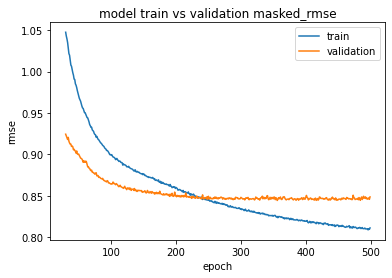

In [72]:
show_rmse(hist_Deep_AE_denoise_dropN, 30)

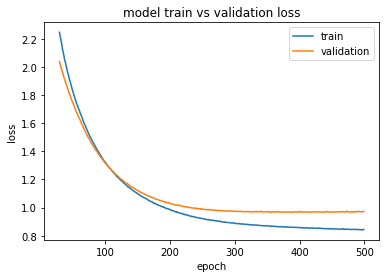

In [73]:
show_error(hist_Deep_AE_denoise_dropN, 30)

In [74]:
test_result_deep = Deep_AE_denoise_dropN.evaluate(users_items_matrix_train_zero, users_items_matrix_test)

6040/6040 [==============================] - 1s 96us/sample - loss: 0.9802 - masked_rmse_clip: 0.8543


As we can see in figures, when the dropout rate increase for the noise, the RMSE started increasing. When the rate was 0.1, the performance actually was better than the baseline but since it’s only 0.002 difference, it may still be in the range of error. It needs cross-validation for further verification.

## Hybrid

Since we have the information about each user, we will try adding the side-information in this model.

### Preprocessing the side information

In [75]:
user_df = pd.read_csv('ml1m_users.csv',sep='\t', encoding='latin-1', 
                      usecols=['user_emb_id', 'gender', 'age', 'occupation'])

user_df.head(5)

,user_emb_id,gender,age,occupation
0,0,F,1,10
1,1,M,56,16
2,2,M,25,15
3,3,M,45,7
4,4,M,25,20


In [76]:
# Transform side information to onehot encoding
user_df['age'] = preprocessing.LabelEncoder().fit(user_df['age']).transform(user_df['age'])
user_df['gender'] = preprocessing.LabelEncoder().fit(user_df['gender']).transform(user_df['gender'])
onehot_df = preprocessing.OneHotEncoder(handle_unknown='ignore', sparse=False).fit(user_df[['gender', 'age', 'occupation']]).transform(user_df[['gender', 'age', 'occupation']])

In [77]:
onehot_df.shape

(6040, 30)

For each user, we have gender, age and occupation and after transforming to one hot encoding format, each user has totally 30 features.

### Concatenate content to input keep output the same

In [78]:
#Concatenate the one hot encoding side information to the rating matrix
user_items_user_info = np.concatenate((users_items_matrix_train_zero, onehot_df), axis=1)

In [79]:
user_items_user_info.shape

(6040, 3736)

For this method, we concatenated the side information to the rating matrix, so the shape of the matrix will be changed from 6040x3706 to 6040x3736.

In [80]:
layers = [256, 512, 256]
dropout = 0.8
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001
# Build model
Deep_AE_concate = Deep_AE_model(user_items_user_info, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode, 30)
Deep_AE_concate.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) 
Deep_AE_concate.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      [(None, 3736)]            0         
_________________________________________________________________
EncLayer0 (Dense)            (None, 256)               956672    
_________________________________________________________________
LatentSpace (Dense)          (None, 512)               131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
DecLayer0 (Dense)            (None, 256)               131328    
_________________________________________________________________
UserScorePred (Dense)        (None, 3706)              952442    
Total params: 2,172,026
Trainable params: 2,172,026
Non-trainable params: 0
_________________________________________________

In [81]:
#hide-output
hist_Deep_AE_concate = Deep_AE_concate.fit(x=user_items_user_info, y=users_items_matrix_train_zero,
                  epochs=500,
                  batch_size=256,
                  validation_data=[user_items_user_info, users_items_matrix_validate], verbose=2)

Train on 6040 samples, validate on 6040 samples
Epoch 1/500
6040/6040 - 1s - loss: 16.3688 - masked_rmse_clip: 2.8567 - val_loss: 14.1419 - val_masked_rmse_clip: 2.8187
Epoch 2/500
6040/6040 - 1s - loss: 11.3248 - masked_rmse_clip: 2.5003 - val_loss: 6.8270 - val_masked_rmse_clip: 1.9725
Epoch 3/500
6040/6040 - 1s - loss: 6.2670 - masked_rmse_clip: 1.8392 - val_loss: 3.9014 - val_masked_rmse_clip: 1.3892
Epoch 4/500
6040/6040 - 1s - loss: 4.2657 - masked_rmse_clip: 1.4853 - val_loss: 3.0646 - val_masked_rmse_clip: 1.1449
Epoch 5/500
6040/6040 - 1s - loss: 3.6921 - masked_rmse_clip: 1.3542 - val_loss: 2.8371 - val_masked_rmse_clip: 1.0719
Epoch 6/500
6040/6040 - 1s - loss: 3.4697 - masked_rmse_clip: 1.3028 - val_loss: 2.7246 - val_masked_rmse_clip: 1.0364
Epoch 7/500
6040/6040 - 1s - loss: 3.3514 - masked_rmse_clip: 1.2778 - val_loss: 2.6525 - val_masked_rmse_clip: 1.0163
Epoch 8/500
6040/6040 - 1s - loss: 3.2422 - masked_rmse_clip: 1.2512 - val_loss: 2.5977 - val_masked_rmse_clip: 1.00

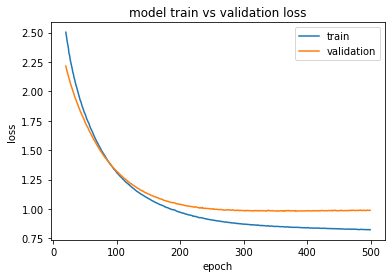

In [82]:
show_error(hist_Deep_AE_concate, 20)

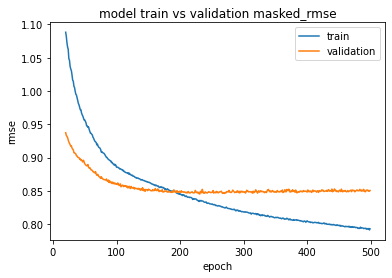

In [83]:
show_rmse(hist_Deep_AE_concate, 20)

We tested this model on the setting of [256, 512, 256]+zero. Adding the side information does not have a limited impact on the result. The error graph, Val RMSE graph and test RMSE are similar to the model without side information. As the repartition of known entries in the dataset is not uniform, the estimates are biased towards users with a lot of rating. For these users, the dataset already has a lot of information and comparing with existing rating features, 30 side information feature will have limited effect. But according to [this](https://arxiv.org/abs/1603.00806) paper, when the users have fewer ratings, the side information will have more effect. 